# Flower Classification with TPUs


In [1]:
#the basics
from matplotlib import pyplot as plt
import math, os, re, gc
import numpy as np, pandas as pd

#deep learning basics
import tensorflow as tf
import tensorflow.keras.backend as K

#get current TensorFlow version fo
print("Currently using Tensorflow version " + tf.__version__)

Currently using Tensorflow version 2.2.0


## Configuration

In [2]:
DEVICE = 'TPU'   #or GPU

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


In [3]:
#get GCS path for flower classification data set
from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')

**To optimize the TPUs bandwith, we cut our dataset into files and then send these files to the different TPU cores. The common format for these files is TFRecords which essentially just takes the pixels of the image and some other information (e.g. a label) and stuffs it into a file. A good number of TFRecord files is 16: so we take our dataset and split it into 16 different TFRecord files and send them to the TPUs**


In [4]:
#for reproducibility
SEED = 34 

#define image size we will use
#IMAGE_SIZE = [224, 224]               
IMAGE_SIZE = [512, 512]               

#how many training samples we want going to TPUs 
BATCH_SIZE = 32 * REPLICAS 

#define aug batch size
AUG_BATCH = BATCH_SIZE

#how many folds we will use to train our model on
FOLDS = 3

#choose training display settings
VERBOSE = 2

#if debugging
FIRST_FOLD_ONLY = False

#list other options we have for image sizes
GCS_PATH_SELECT = {
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

In [5]:
#decodes and converts image to float in [0,1]
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    #TPU needs to be explicitly told image size
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


In [6]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    
    #returns a dataset of (image, label) pairs
    return image, label

def read_unlabeled_tfrecord(example, return_image_name):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # [] means single entry
    }
    
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    #returns a dataset of image(s)
    return image, idnum if return_image_name else 0


#apply some stock augmentations using tf.image
def data_augment(img, label, flip_only = False):

    if flip_only:
        img = tf.image.random_flip_left_right(img)
    
    else:
        img = tf.image.random_flip_left_right(img)
        #some other easy transformations we can apply
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
        
    return img, label

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [7]:
#define pre fetching strategy
AUTO = tf.data.experimental.AUTOTUNE

#use tf.io.gfile.glob to find our training and test files from GCS bucket
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')
    
#set up some parameters now
NUM_TRAINING_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (1./FOLDS) )
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES / BATCH_SIZE 

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 10976 training images, 5488 validation images, 7382 unlabeled test images


In [8]:
def get_dataset(files, course_drop = False, grid_mask = False, mat_aug = False, cutmixup = False, one_hot = False,
                all_aug = False, shuffle = False, repeat = False, labeled = True, return_image_names = True,
                batch_size = BATCH_SIZE, dim = IMAGE_SIZE[0]):
   
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)

    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(2048)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)  
        
    #apply course drop
    if course_drop:
        ds = ds.map(data_augment, num_parallel_calls = AUTO)
        ds = ds.map(lambda img, label: (dropout(img), label), num_parallel_calls = AUTO)
    
    #apply grid mask
    if grid_mask:
        ds = ds.map(data_augment, num_parallel_calls = AUTO)
        ds = ds.map(apply_grid_mask, num_parallel_calls = AUTO)
    
    #apply rot/shear/zoom augmentation
    if mat_aug:
        ds = ds.map(data_augment, num_parallel_calls = AUTO)
        ds = ds.map(transform, num_parallel_calls = AUTO)
     
    #apply all the above aug
    if all_aug:
        ds = ds.map(data_augment, num_parallel_calls = AUTO)
        ds = ds.map(apply_all_aug, num_parallel_calls = AUTO)
        
    
    #apply CutMix/MixUp combination
    if cutmixup:
        #ds = ds.map(data_augment, num_parallel_calls = AUTO)
        
        #need to batch to use CutMix/mixup
        ds = ds.batch(AUG_BATCH)
        ds = ds.map(cut_and_mix, num_parallel_calls = AUTO)
        
        #now unbatch and shuffle before re-batching
        ds = ds.unbatch()
        ds = ds.shuffle(2048)

    if one_hot:
        ds = ds.map(onehot, num_parallel_calls = AUTO)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTO)
    
    return ds

## Visualization

In [9]:
#define flower classes for labeling purposes
classes = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [10]:
#numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #binary strings are image IDs
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    #If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return classes[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(classes[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                classes[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    #auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    #size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    #display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else classes[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #get optimal spacing
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [11]:
#first look at training dataset
training_dataset = get_dataset(TRAINING_FILENAMES, labeled = True, course_drop = False, all_aug = False,
                               grid_mask = False, mat_aug = False, cutmixup = False, shuffle = True, repeat = True)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [12]:
#first look at test dataset
test_dataset = get_dataset(TEST_FILENAMES, labeled = False, course_drop = False, grid_mask = False,
                           mat_aug = False, all_aug = False, shuffle = True, repeat = False)
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

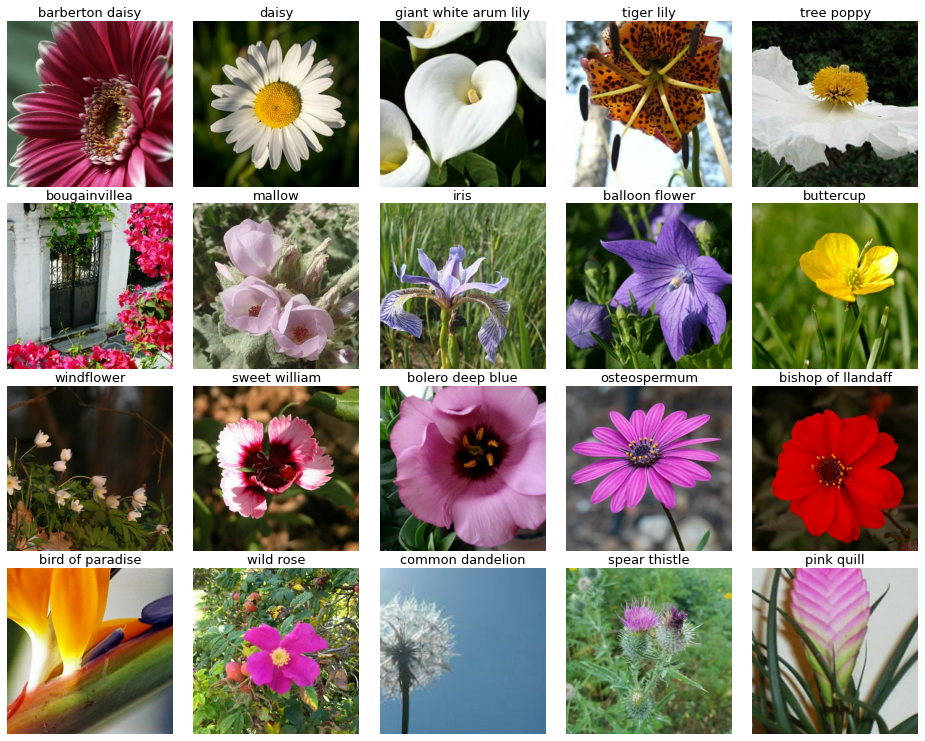

In [13]:
#view batch of flowers from train
display_batch_of_images(next(train_batch))
#you can run this cell again and it will load a new batch

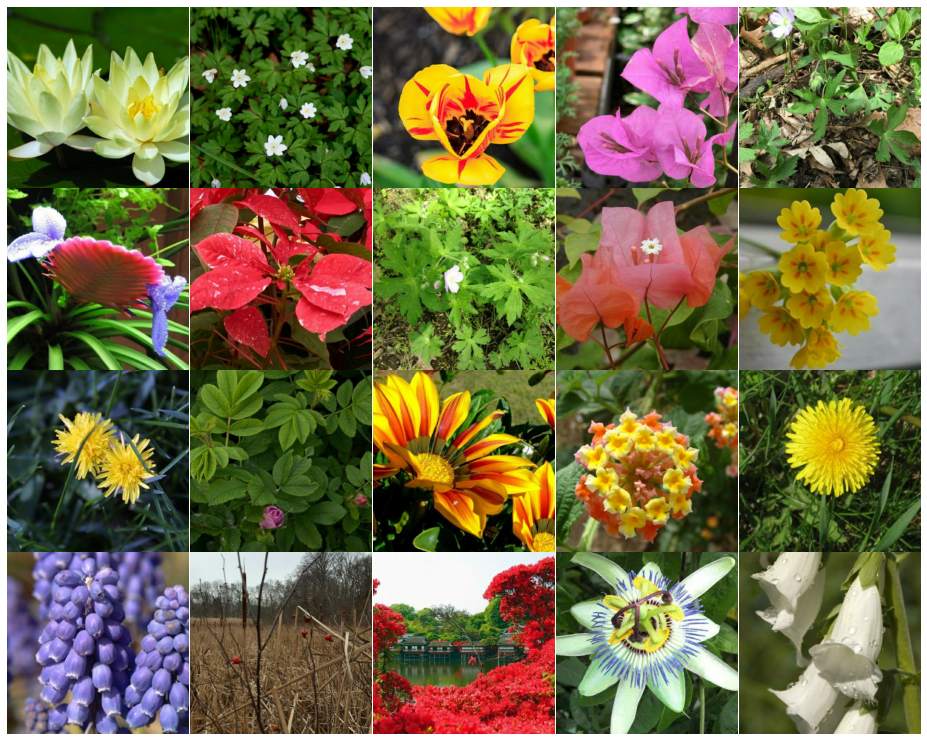

In [14]:
#view batch of flowers from test
display_batch_of_images(next(test_batch))
#you can run this cell again and it will load a new batch

## Augmentation
**Rotation, Shift, Zoom, Shear**

In [15]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [16]:
def transform(image, label, DIM = IMAGE_SIZE[0]):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted

    XDIM = DIM % 2
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

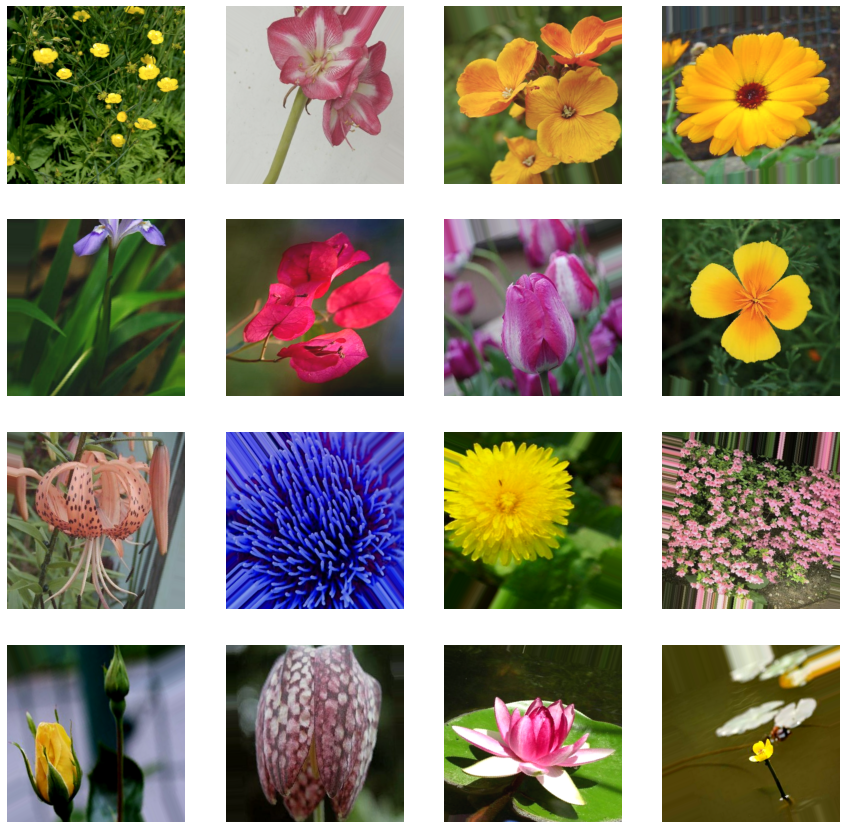

In [17]:
#view augmentation
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(TRAINING_FILENAMES, labeled = True, mat_aug = True,
                           course_drop = False, cutmixup = False, shuffle = True, repeat = True)

all_elements = all_elements.unbatch().batch(20)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [18]:
def dropout(image, DIM = IMAGE_SIZE[0], PROBABILITY = 1, CT = 8, SZ = 0.2):
    
    prob = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (prob==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):

        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        WIDTH = tf.cast( SZ*DIM,tf.int32) * prob
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    image = tf.reshape(image,[DIM,DIM,3])
    
    return image

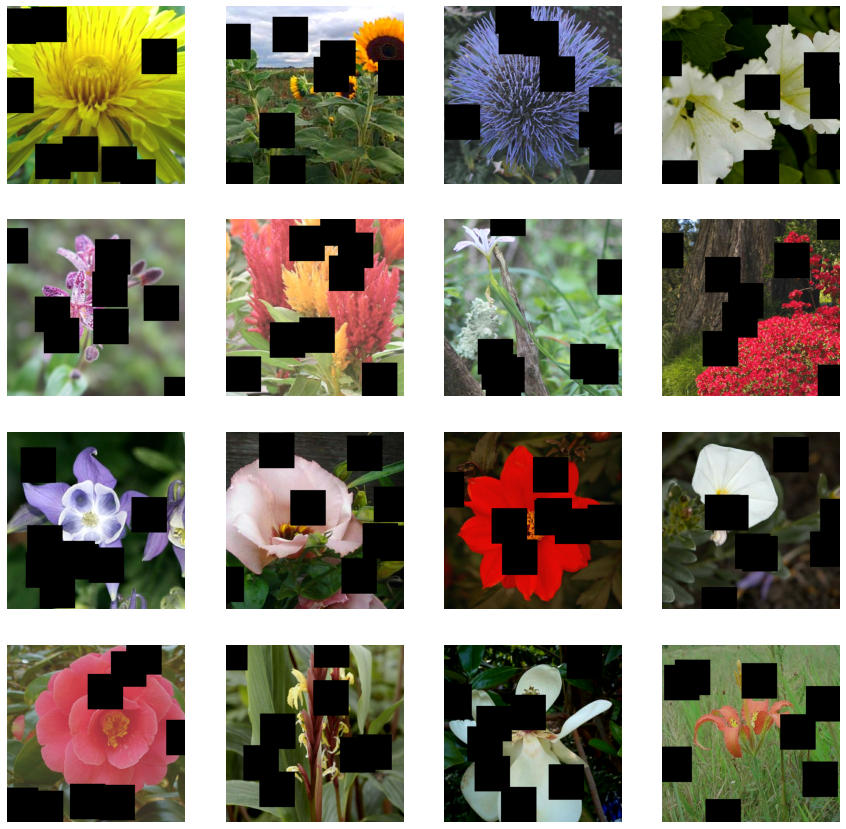

In [19]:
#view what course dropout looks like
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(TRAINING_FILENAMES, labeled = True, mat_aug = False, cutmixup = False,
                           grid_mask = False, course_drop = True, shuffle = True, repeat = True)

all_elements = all_elements.unbatch().batch(20)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

## GridMask

In [20]:
AugParams = {
    'd1' : 100,
    'd2': 160,
    'rotate' : 45,
    'ratio' : 0.4
}

In [21]:
def transform2(image, inv_mat, image_shape):

    h, w, c = image_shape
    cx, cy = w//2, h//2

    new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
    new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
    new_zs = tf.ones([h*w], dtype=tf.int32)

    old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
    old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)

    clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
    clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
    clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)

    old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
    old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
    new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
    new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))

    old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
    new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
    rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
    rotated_image_channel = list()
    for i in range(c):
        vals = rotated_image_values[:,i]
        sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
        rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))

    return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):

    def get_rotation_mat_inv(angle):
        #transform to radian
        angle = math.pi * angle / 180

        cos_val = tf.math.cos(angle)
        sin_val = tf.math.sin(angle)
        one = tf.constant([1], tf.float32)
        zero = tf.constant([0], tf.float32)

        rot_mat_inv = tf.concat([cos_val, sin_val, zero,
                                     -sin_val, cos_val, zero,
                                     zero, zero, one], axis=0)
        rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])

        return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform2(image, rot_mat_inv, image_shape)


def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):

    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges <0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges <0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask

def apply_grid_mask(image, label):
    mask = GridMask(IMAGE_SIZE[0],
                    IMAGE_SIZE[1],
                    AugParams['d1'],
                    AugParams['d2'],
                    AugParams['rotate'],
                    AugParams['ratio'])
    
    if IMAGE_SIZE[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)

    return tf.cast(image * tf.cast(mask, tf.float32), tf.float32), label

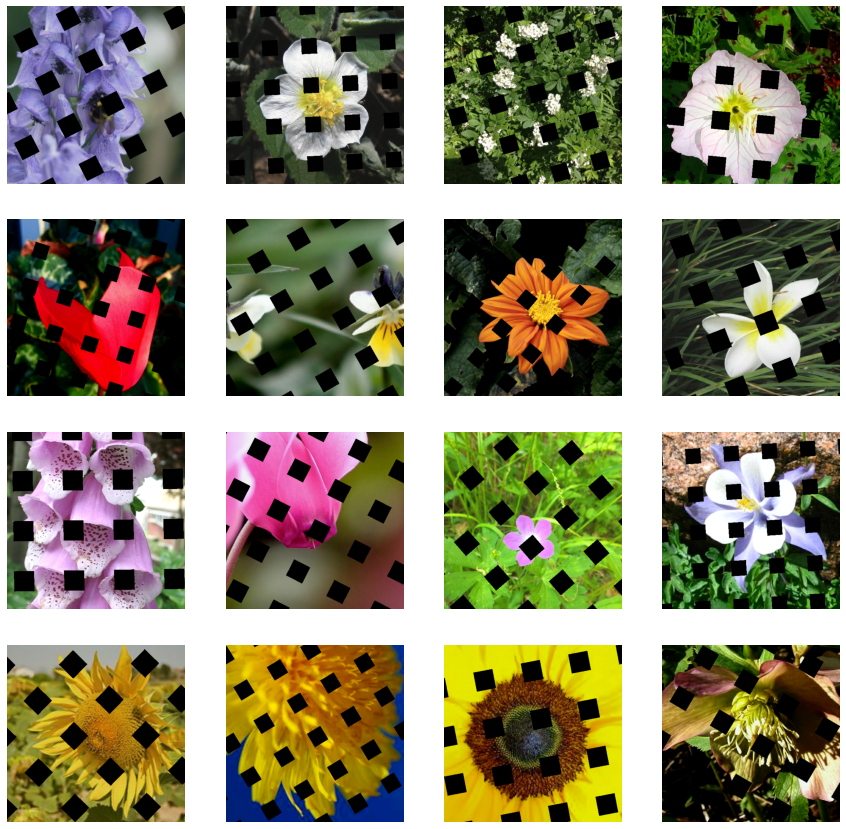

In [22]:
#view what grid mask looks like
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(TRAINING_FILENAMES, labeled = True, grid_mask = True, mat_aug = False,
                           cutmixup = False, course_drop = False, shuffle = True, repeat = True)

all_elements = all_elements.unbatch().batch(20)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [23]:
def apply_all_aug(img, label, no_grid = False):
    
    if tf.random.uniform([],0,1) > .5:
        if tf.random.uniform([],0,1) > .5:
            img, label = transform(img, label)
            
        #apply droupout  
        else:
            img = dropout(img, PROBABILITY = 1)
            
    else:
        if not no_grid:
        #apply grid mask
            if tf.random.uniform([],0,1) > .5:
                img, label = apply_grid_mask(img, label)
                
            else:
                #do nothing
                img, label = img, label
                
        else:
        #apply transform again 
            if tf.random.uniform([],0,1) > .5:
                img, label = transform(img, label)
                
            else:
                #do nothing
                img, label = img, label
            
    return img, label

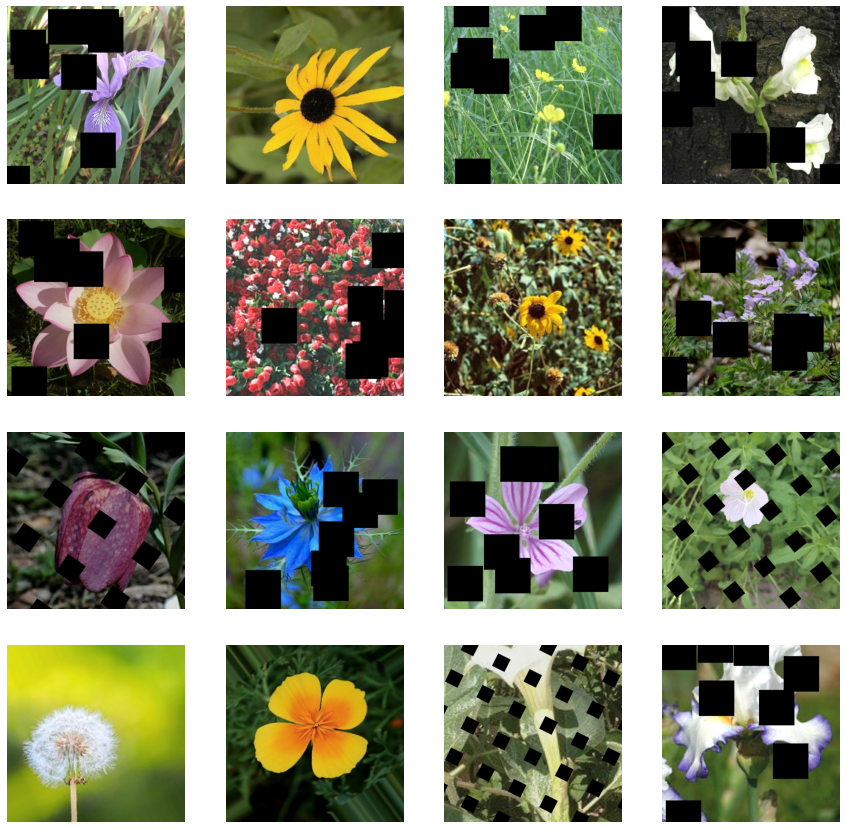

In [24]:
#view what augmentation combination looks like
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(TRAINING_FILENAMES, labeled = True, grid_mask = False, all_aug = True, 
                           course_drop = False, cutmixup = False, shuffle = True, repeat = True)

all_elements = all_elements.unbatch().batch(20)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [25]:
#need to one hot encode images so we can blend their labels like above
def onehot(image,label):
    CLASSES = len(classes)
    return image,tf.one_hot(label,CLASSES)

In [26]:
def mixup(image, label, PROBABILITY = 1.0, DIM = IMAGE_SIZE[0]):
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):

        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)

        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P

        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)

        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)

    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [27]:
def cutmix(image, label, PROBABILITY = 1.0, DIM = IMAGE_SIZE[0]):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):

        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)

        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)

        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1)
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)

        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
        
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

### MixUp + CutMix

In [28]:
#create function to apply both cutmix and mixup
def cut_and_mix(image, label, DIM = IMAGE_SIZE[0]):
    CLASSES = len(classes)
    
    #define how often we want to do activate cutmix or mixup
    SWITCH = 1/2
    
    #define how often we want cutmix or mixup to activate when switch is active
    CUTMIX_PROB = 2/3
    MIXUP_PROB = 2/3
    
    #apply cutmix and mixup
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image3, label3 = mixup(image, label, MIXUP_PROB)
    imgs = []; labs = []
    
    for j in range(BATCH_SIZE):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
        
    #must explicitly reshape so TPU complier knows output shape
    image4 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(BATCH_SIZE,CLASSES))
    return image4,label4

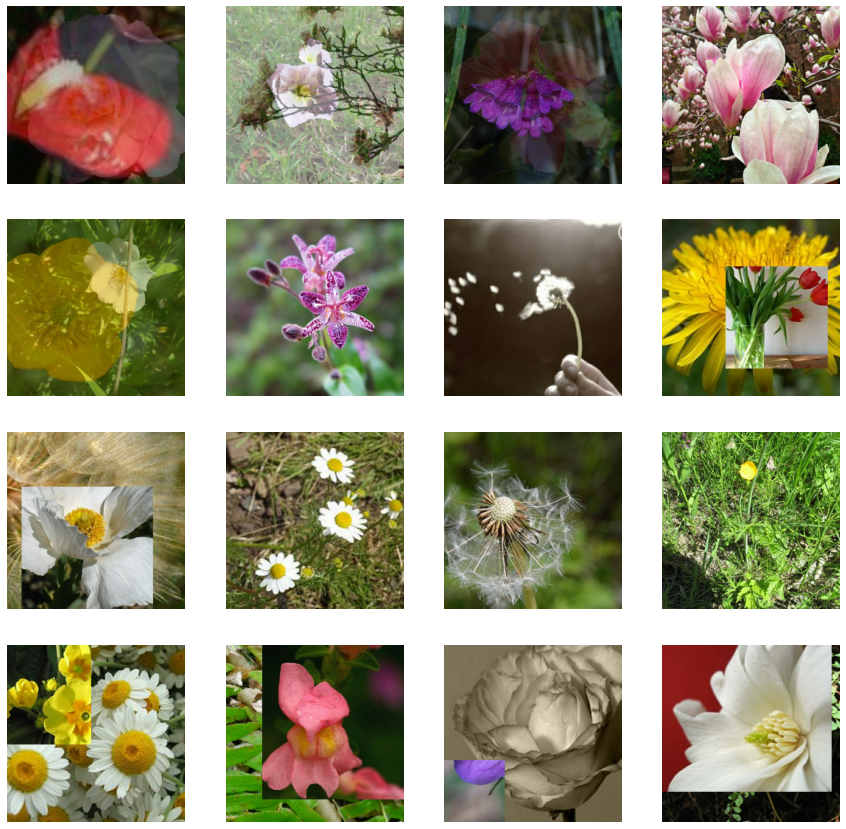

In [29]:
#view what CutMix/MixUp combination looks like
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(TRAINING_FILENAMES, labeled = True, grid_mask = False, all_aug = False,  
                           cutmixup = True, course_drop = False, shuffle = True, repeat = True)

all_elements = all_elements.unbatch().batch(20)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

## Model Training

Learning rate schedule: 1e-05 to 0.0004 to 1.18e-05


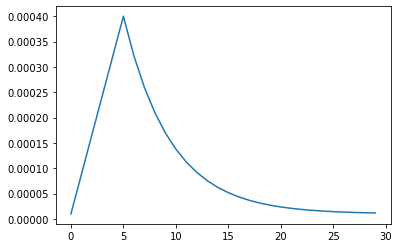

In [30]:
#define epoch parameters
EPOCHS = 30                

#define learning rate parameters
LR_START = 0.00001
LR_MAX = 0.00005 * 8
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_DECAY = .8

#define ramp up and decay
def lr_schedule(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = True)

#visualize learning rate schedule
rng = [i for i in range(EPOCHS)]
y = [lr_schedule(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [31]:
#import DenseNet201, Xception, InceptionV3, and InceptionResNetV2
from tensorflow.keras.applications import DenseNet201, Xception, InceptionV3, InceptionResNetV2

#requirements to use EfficientNet(s)
!pip install -q efficientnet
import efficientnet.tfkeras as efn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [32]:
#helper function to create our model
def get_DenseNet201():
    CLASSES = len(classes)
    with strategy.scope():
        dnet = DenseNet201(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        dnet.trainable = True
        model = tf.keras.Sequential([
            dnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy', 
        metrics=['categorical_accuracy']
    )
    return model


#create Xception model
def get_Xception():
    CLASSES = len(classes)
    with strategy.scope():
        xception = Xception(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        xception.trainable = True
        model = tf.keras.Sequential([
            xception,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model


#create Inception model
def get_InceptionV3():
    CLASSES = len(classes)
    with strategy.scope():
        inception = InceptionV3(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        inception.trainable = True
        model = tf.keras.Sequential([
            inception,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model


#create InceptionResNet model
def get_InceptionResNetV2():
    CLASSES = len(classes)
    with strategy.scope():
        inception_res = InceptionResNetV2(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        inception_res.trainable = True
        model = tf.keras.Sequential([
            inception_res,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model


#create EfficientNetB4 model
def get_EfficientNetB4(one_hot = False):
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB4(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])

    if one_hot: 
        model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

    else: 
        model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
        
    return model


#create EfficientNetB5 model
def get_EfficientNetB5(one_hot = False):
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB5(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax', dtype = 'float32')
        ])

    if one_hot: 
        model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

    else: 
        model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

    return model


#create EfficientNetB6 model
def get_EfficientNetB6():
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB6(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax',dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model


#create EfficientNetB7 model
def get_EfficientNetB7():
    CLASSES = len(classes)
    with strategy.scope():
        efficient = efn.EfficientNetB7(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(CLASSES, activation = 'softmax', dtype = 'float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

In [33]:
from sklearn.model_selection import KFold
#train and cross validate in folds

histories = []
preds = np.zeros((count_data_items(TEST_FILENAMES),104))

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
kfold = KFold(FOLDS, shuffle = True, random_state = SEED)

for f, (train_index, val_index) in enumerate(kfold.split(TRAINING_FILENAMES)):
    
    #show fold info
    if DEVICE=='TPU':
        #hack to clear TPU memory
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('FOLD',f+1); print('#'*25)
    
    #convert files to datasets
    train_ds = get_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[train_index]['TRAINING_FILENAMES']),
                           course_drop = False, mat_aug = False, grid_mask = False, all_aug = False, cutmixup = True,
                           labeled = True, return_image_names = True, repeat = True, shuffle = True)  

    val_ds = get_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_index]['TRAINING_FILENAMES']),
                        course_drop = False, mat_aug = False, grid_mask = False, all_aug = False, cutmixup = False,
                        one_hot = True, labeled = True, return_image_names = False, repeat = False, shuffle = True)

    #and go!
    print('Getting model...'); print(''); print('Training model...')
    model = get_EfficientNetB5(one_hot = True)
    history = model.fit(train_ds, validation_data = val_ds, callbacks = [lr_callback],
                        verbose = VERBOSE, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS
    )
    
    histories.append(history)
    
    print('Predicting test without TTA')
    ds_test = get_dataset(TEST_FILENAMES, course_drop = False, mat_aug = False, grid_mask = False, all_aug = False, cutmixup = False,
                             labeled = False, return_image_names = False, repeat = False, shuffle = False)   
    pred = model.predict(ds_test,verbose = VERBOSE)
    preds += pred * 1 / FOLDS
     
    #so we don't hit memory limits
    del model; z = gc.collect()
    
    if FIRST_FOLD_ONLY:
        break

#########################
FOLD 1
#########################
Getting model...

Training model...
115261440/115255328 [==============================] - 4s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
43/42 - 76s - loss: 4.6250 - categorical_accuracy: 0.0190 - val_loss: 4.5830 - val_categorical_accuracy: 0.0283 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30
43/42 - 47s - loss: 3.8508 - categorical_accuracy: 0.2639 - val_loss: 3.0033 - val_categorical_accuracy: 0.4373 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30
43/42 - 51s - loss: 2.3953 - categorical_accuracy: 0.5402 - val_loss: 1.2765 - val_categorical_accuracy: 0.7455 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30
43/42 - 52s - loss: 1.6926 - categorical_accuracy: 0.7088 - val_loss: 0.7056 - val_categorical_accuracy: 0.8515 - lr: 2.440

In [34]:
#define function to visualize learning curves
def plot_learning_curves(histories, one_hot = False): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    
    #plot accuracies
    if one_hot:
        for i in range(0, 3):
            ax[0].plot(histories[i].history['categorical_accuracy'], color = 'C0')
            ax[0].plot(histories[i].history['val_categorical_accuracy'], color = 'C1')

    else:
        for i in range(0, 3):
            ax[0].plot(histories[i].history['sparse_categorical_accuracy'], color = 'C0')
            ax[0].plot(histories[i].history['val_sparse_categorical_accuracy'], color = 'C1')

    #plot losses
    for i in range(0, 3):
        ax[1].plot(histories[i].history['loss'], color = 'C0')
        ax[1].plot(histories[i].history['val_loss'], color = 'C1')

    #fix legend
    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper right')
    
    #set master titles
    fig.suptitle("Model Performance", fontsize=14)
    
    #label axis
    for i in range(0,2):
        ax[0].set_ylabel('Accuracy')
        ax[0].set_xlabel('Epoch')
        ax[1].set_ylabel('Loss')
        ax[1].set_xlabel('Epoch')

    return plt.show()

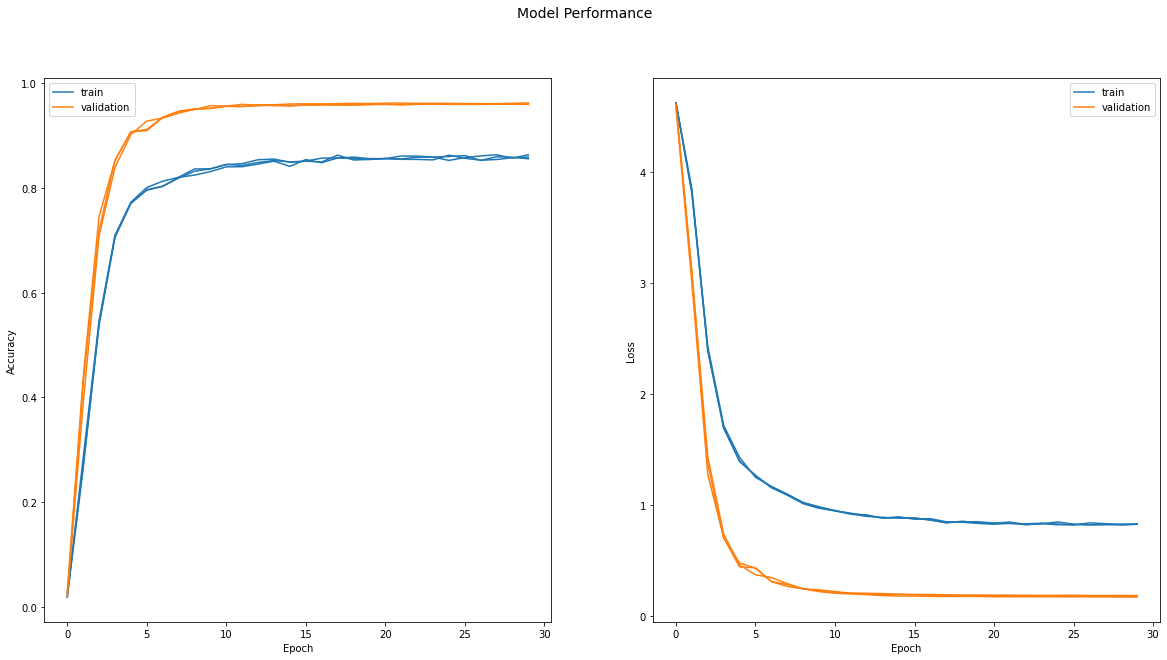

In [35]:
#look at our learning curves to check bias/variance trade off
if not FIRST_FOLD_ONLY:
    plot_learning_curves(histories, one_hot = True)

## Submission

In [36]:
#dummy test dataset to grab image names
test_ds = get_dataset(TEST_FILENAMES, labeled = False, repeat = False, return_image_names = True)
test_images_ds = test_ds.map(lambda image, idnum: image)

#get test ids for submission
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

#create non TTA submission
submission = pd.DataFrame()
submission['id'] = test_ids
submission['label'] = preds.argmax(axis = 1)
submission.to_csv('submission.csv', index = False)
submission.head(10)

id  label
0  252d840db     67
1  1c4736dea     28
2  c37a6f3e9     83
3  00e4f514e    103
4  59d1b6146     70
5  8d808a07b     53
6  aeb67eefb     52
7  53cfc6586     29
8  aaa580243     82
9  d907ca7c0     13